In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('/datasets/eteplygina/combined_data.csv')
data = data.drop(['time_rounded', 'shock_time', 'ethnicity', 'gender', 'height', 'weight', 'relative_time', 'age'], axis=1)

# Create label dictionary
label_dict = data.groupby('id')['label'].first().to_dict()

# Split data into train and test sets while preserving IDs
train_ids, test_ids = train_test_split(data['id'].unique(), test_size=0.2, random_state=42)

# Normalize the data for train and test sets separately
scaler = StandardScaler()

# Filter the DataFrame to extract the rows corresponding to train_ids and test_ids
train_data_filtered = data[data['id'].isin(train_ids)].drop(['label'], axis=1)
test_data_filtered = data[data['id'].isin(test_ids)].drop(['label'], axis=1)

# Normalize features
train_data_filtered.iloc[:, 1:] = scaler.fit_transform(train_data_filtered.iloc[:, 1:]).astype('float64')
test_data_filtered.iloc[:, 1:] = scaler.transform(test_data_filtered.iloc[:, 1:]).astype('float64')

# Add labels back to train and test sets for adjustment
train_data_filtered['label'] = data[data['id'].isin(train_ids)]['label'].values
test_data_filtered['label'] = data[data['id'].isin(test_ids)]['label'].values

# Function to relabel positive patients
def relabel_positive_patients(data, label_dict, window_size):
    for id in data['id'].unique():
        if label_dict[id] == 1:
            id_data = data[data['id'] == id]
            end_index = len(id_data)
            start_index = max(0, end_index - window_size * 3) 
            data.loc[data['id'] == id, 'label'] = 0
            data.loc[id_data.iloc[start_index:end_index].index, 'label'] = 1
    return data

# Relabel positive patients for train and test data
train_data_relabelled = relabel_positive_patients(train_data_filtered, label_dict, window_size=8)
test_data_relabelled = relabel_positive_patients(test_data_filtered, label_dict, window_size=8)

# Create sliding windows with 50% overlap and assign window labels for later use
def create_sliding_windows_with_labels(data, ids, window_size, overlap):
    windows = []
    window_labels = []
    row_labels = []
    for id in ids:
        id_data = data[data['id'] == id].drop(['id', 'label'], axis=1).values  # Exclude 'id' and 'label' columns
        id_labels = data[data['id'] == id]['label'].values
        for start in range(0, len(id_data) - window_size + 1, overlap):
            window = id_data[start:start + window_size]
            window_label = id_labels[start:start + window_size].max()  # Max aggregation for window labels
            row_label = id_labels[start:start + window_size]  # Keep original row labels for the window
            windows.append(window)
            window_labels.append(window_label)
            row_labels.append(row_label)
    return np.array(windows), np.array(window_labels), np.array(row_labels).reshape(-1, window_size, 1)

# Create sliding windows for train and test sets
train_windows, train_window_labels, train_labels = create_sliding_windows_with_labels(train_data_relabelled, train_ids, window_size=8, overlap=4)
test_windows, test_window_labels, test_labels = create_sliding_windows_with_labels(test_data_relabelled, test_ids, window_size=8, overlap=4)

print("Train windows shape:", train_windows.shape)
print("Test windows shape:", test_windows.shape)
print("Train window labels shape:", train_window_labels.shape)
print("Test window labels shape:", test_window_labels.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)


Train windows shape: (232197, 8, 7)
Test windows shape: (59733, 8, 7)
Train window labels shape: (232197,)
Test window labels shape: (59733,)
Train labels shape: (232197, 8, 1)
Test labels shape: (59733, 8, 1)


In [34]:
print(train_data_relabelled[500:1000])
print(train_labels[:15])
print(train_window_labels[:10])

            id  heartrate       sbp       dbp       mbp  respiration  \
659   30009505  -0.689923 -0.059857  1.413629  0.899059     0.762120   
660   30009505  -0.521964 -0.555647  0.534479  0.271940    -0.598043   
661   30009505  -0.521964 -0.555647  0.534479  0.271940    -0.598043   
662   30009505  -0.242033 -0.014786  0.848462  0.773635    -0.792351   
663   30009505  -0.242033 -0.014786  0.848462  0.773635    -0.792351   
...        ...        ...       ...       ...       ...          ...   
1154  38159053   1.381571 -0.510575  0.722869  0.271940     0.373502   
1155  38159053   1.381571 -0.510575  0.722869  0.271940     0.373502   
1156  38159053   1.717489 -0.285216  0.660072  0.209228     0.762120   
1157  38159053   1.717489 -0.285216  0.660072  0.209228     0.762120   
1158  38159053   1.493543 -0.645791  0.534479  0.083805     1.150737   

      temperature      spo2  label  
659      0.282237  0.476982      0  
660      0.602465  0.790189      0  
661      0.602465  0.790

In [57]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# Calculate the number of positive and negative samples in the training dataset
num_positive_samples = np.sum(train_labels == 1)
num_negative_samples = np.sum(train_labels == 0)
total_samples = num_positive_samples + num_negative_samples

# Calculate weights based on inverse frequency
window_positive_weight = total_samples / (2 * num_positive_samples)
window_negative_weight = total_samples / (2 * num_negative_samples)

print(f"Calculated window positive weight: {window_positive_weight}")
print(f"Calculated window negative weight: {window_negative_weight}")

# # Calculate the ratio of 1s to 0s in the training dataset
# num_positive_samples = np.sum(train_labels == 1)
# num_negative_samples = np.sum(train_labels == 0)
# total_samples = num_positive_samples + num_negative_samples

# # Set the weights based on this ratio
# window_positive_weight = num_negative_samples / total_samples
# window_negative_weight = num_positive_samples / total_samples

# print(f"Calculated window positive weight: {window_positive_weight}")
# print(f"Calculated window negative weight: {window_negative_weight}")

# Custom weighted binary cross-entropy loss function at the window level
def weighted_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    weights = y_true * window_positive_weight + (1 - y_true) * window_negative_weight
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * tf.reshape(weights, tf.shape(bce))  # Reshape weights to match bce shape
    return tf.reduce_mean(weighted_bce)



def build_model(num_layers, lstm_units, learning_rate):
    model = Sequential()
    
    for _ in range(num_layers):
        model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(8, 7)))
        # model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=weighted_binary_crossentropy,
        metrics=['accuracy']
    )
    model.summary()
    return model

# Initial hyperparameters
num_layers = 3
lstm_units = 64
learning_rate = 0.001
epochs = 30
batch_size = 32
patience = 3

# Build the model
model = build_model(num_layers=num_layers, lstm_units=lstm_units, learning_rate=learning_rate)

# Train the model
history = model.fit(
    train_windows, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_windows, test_labels)
)


Calculated window positive weight: 0.9453443627609315
Calculated window negative weight: 0.05465563723906855


2024-06-23 22:28:40.537247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 22:28:40.538406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 22:28:40.539231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 8, 64)             18432     
                                                                 
 lstm_13 (LSTM)              (None, 8, 64)             33024     
                                                                 
 lstm_14 (LSTM)              (None, 8, 64)             33024     
                                                                 
 dense_4 (Dense)             (None, 8, 1)              65        
                                                                 
Total params: 84,545
Trainable params: 84,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


2024-06-23 22:28:40.781603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 22:28:40.782562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 22:28:40.783209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7253/7257 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.6676

2024-06-23 22:29:20.087830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 22:29:20.088860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 22:29:20.089579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7257/7257 [==============================] - 43s 6ms/step - loss: 0.0626 - accuracy: 0.6676 - val_loss: 0.0592 - val_accuracy: 0.6352
Epoch 2/30
7257/7257 [==============================] - 40s 5ms/step - loss: 0.0613 - accuracy: 0.6630 - val_loss: 0.0594 - val_accuracy: 0.6076
Epoch 3/30
7257/7257 [==============================] - 40s 5ms/step - loss: 0.0608 - accuracy: 0.6695 - val_loss: 0.0587 - val_accuracy: 0.6619
Epoch 4/30
7257/7257 [==============================] - 39s 5ms/step - loss: 0.0604 - accuracy: 0.6765 - val_loss: 0.0587 - val_accuracy: 0.6743
Epoch 5/30
7257/7257 [==============================] - 39s 5ms/step - loss: 0.0601 - accuracy: 0.6792 - val_loss: 0.0587 - val_accuracy: 0.6238
Epoch 6/30
7257/7257 [==============================] - 39s 5ms/step - loss: 0.0598 - accuracy: 0.6825 - val_loss: 0.0586 - val_accuracy: 0.6658
Epoch 7/30
7257/7257 [==============================] - 39s 5ms/step - loss: 0.0594 - accuracy: 0.6855 - val_loss: 0.0584 - val_accuracy: 0.7

In [58]:
# Make window-level predictions
threshold = 0.5
test_predictions = model.predict(test_windows)
test_predictions_binary = (test_predictions > threshold).astype(int)

# Max aggregation of window-level predictions
def max_aggregation(predictions):
    return np.max(predictions, axis=1)

# Aggregating test predictions using max aggregation
test_aggregated_predictions = max_aggregation(test_predictions)

# Binarize aggregated predictions based on the threshold
test_aggregated_predictions_binary = (test_aggregated_predictions > threshold).astype(int)

# Flatten window labels for evaluation
test_window_labels_flattened = test_window_labels.flatten()

# Evaluate predictions
accuracy = np.mean(test_aggregated_predictions_binary.flatten() == test_window_labels_flattened)
precision = np.sum((test_aggregated_predictions_binary.flatten() == 1) & (test_window_labels_flattened == 1)) / np.sum(test_aggregated_predictions_binary.flatten() == 1)
recall = np.sum((test_aggregated_predictions_binary.flatten() == 1) & (test_window_labels_flattened == 1)) / np.sum(test_window_labels_flattened == 1)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

2024-06-23 22:49:06.581871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 22:49:06.582925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 22:49:06.583693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

   1/1867 [..............................] - ETA: 17:05

2024-06-23 22:49:06.837892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-23 22:49:06.838886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-23 22:49:06.839631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1867/1867 [==============================] - 4s 2ms/step
Accuracy: 0.518724992885005
Precision: 0.0860036472580435
Recall: 0.7950030102347984
F1 Score: 0.1552159858947987


In [54]:
print(test_aggregated_predictions)
print(test_aggregated_predictions_binary[100:500])
print(test_window_labels_flattened)

[[0.9296566 ]
 [0.92737246]
 [0.88292104]
 ...
 [0.6943616 ]
 [0.49251908]
 [0.8831917 ]]
[[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]


In [50]:
print(test_predictions)
print(test_aggregated_predictions_binary)

[[[0.59484476]
  [0.5722768 ]
  [0.5535862 ]
  ...
  [0.9083668 ]
  [0.9410931 ]
  [0.92014664]]

 [[0.45726267]
  [0.8423946 ]
  [0.8721418 ]
  ...
  [0.18168333]
  [0.2903837 ]
  [0.07890044]]

 [[0.4824368 ]
  [0.63388664]
  [0.5961886 ]
  ...
  [0.29796964]
  [0.22482175]
  [0.10598339]]

 ...

 [[0.602567  ]
  [0.6123585 ]
  [0.7639293 ]
  ...
  [0.8449285 ]
  [0.8181501 ]
  [0.35429466]]

 [[0.44412115]
  [0.37099373]
  [0.45313314]
  ...
  [0.01900106]
  [0.09363583]
  [0.1398922 ]]

 [[0.62556505]
  [0.7084202 ]
  [0.5074567 ]
  ...
  [0.41543213]
  [0.20308758]
  [0.07643733]]]
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


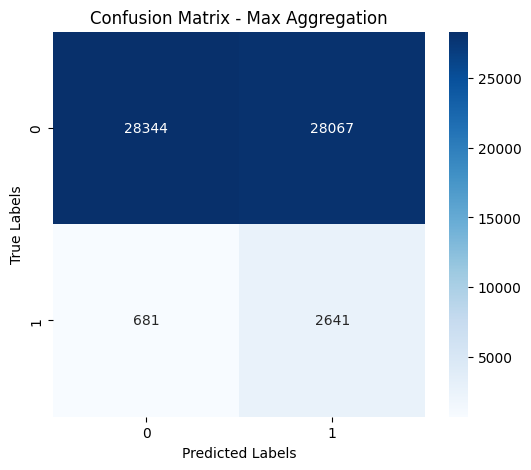

1867/1867 [==============================] - 3s 2ms/step


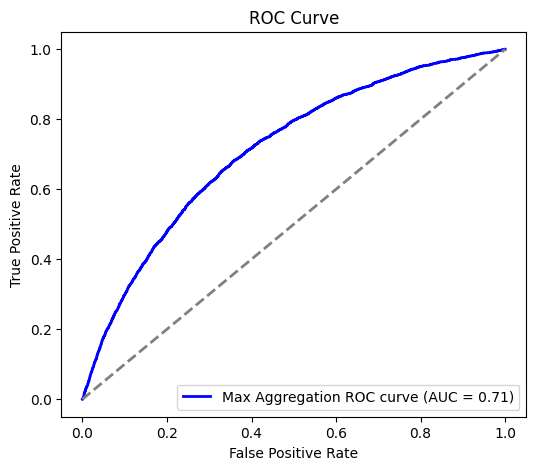

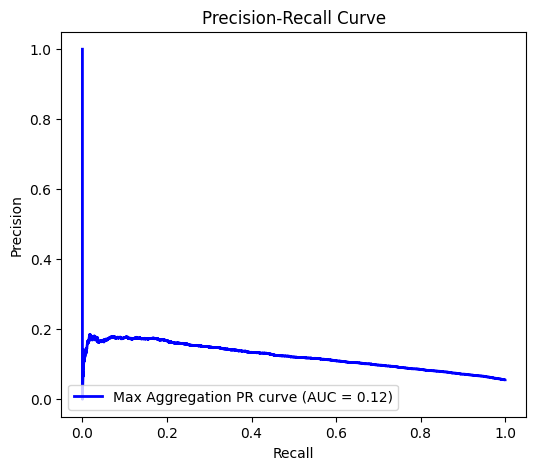

In [59]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
conf_matrix_max = confusion_matrix(test_window_labels_flattened, test_aggregated_predictions_binary.flatten())

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_max, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Max Aggregation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC and Precision-Recall Curves
test_probs = model.predict(test_windows).flatten()
test_aggregated_probs = max_aggregation(test_probs.reshape(-1, 8))

# Calculate ROC curve and AUC
fpr_max, tpr_max, _ = roc_curve(test_window_labels_flattened, test_aggregated_probs)
roc_auc_max = roc_auc_score(test_window_labels_flattened, test_aggregated_probs)

# Calculate Precision-Recall curve and AUC
precision_max, recall_max, _ = precision_recall_curve(test_window_labels_flattened, test_aggregated_probs)
prc_auc_max = auc(recall_max, precision_max)

# Plotting the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_max, tpr_max, color='blue', lw=2, label='Max Aggregation ROC curve (AUC = %0.2f)' % roc_auc_max)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plotting the Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall_max, precision_max, color='blue', lw=2, label='Max Aggregation PR curve (AUC = %0.2f)' % prc_auc_max)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
